# Bag of tricks for efficient text classification

### Import the necessary stuff

In [31]:
import os
import os.path
import nltk
import string
import fasttext
import numpy as np
import pandas as pd
import tensorflow as tf
from smart_open import smart_open
import matplotlib.image as img
import matplotlib.pyplot as plt
from gensim.models import FastText
from gensim.models import Word2Vec
from gensim.models import KeyedVectors
from gensim.models.word2vec import Text8Corpus
from sklearn.cluster import KMeans
from collections import defaultdict
from nltk import word_tokenize as tokenize
from scipy.spatial.distance import squareform, pdist
from nltk.stem.snowball import SnowballStemmer as stemmer
from sklearn.feature_extraction.text import TfidfVectorizer

# inline matplotlib
%matplotlib inline

### Model Architecture

#### Probability distribution over predefined classes

$$
\\- \frac{1}{N}\sum_{n=1}^{N} y_n \log(f(BAx_n))
\\
where\\
x_n = normalized \hspace{0.075cm} bag \hspace{0.075cm} of \hspace{0.075cm} features \hspace{0.075cm} of \hspace{0.075cm} the \hspace{0.075cm} n^{th} \hspace{0.075cm} document\\
y_n = the \hspace{0.075cm} label\\
A, B = weight \hspace{0.075cm} matrices\\
$$

#### Probability of path from root of the node

$$
\\P(n_{l+1}) = \prod_{i=1}^{l} P(n_i)
\\ where \\
l+1 \hspace{0.075cm} = \hspace{0.075cm} Depth \hspace{0.075cm} of \hspace{0.075cm} the \hspace{0.075cm} node \hspace{0.075cm} \\
n_i \hspace{0.075cm} = \hspace{0.075cm} i^{th} \hspace{0.075cm} parent\\
$$

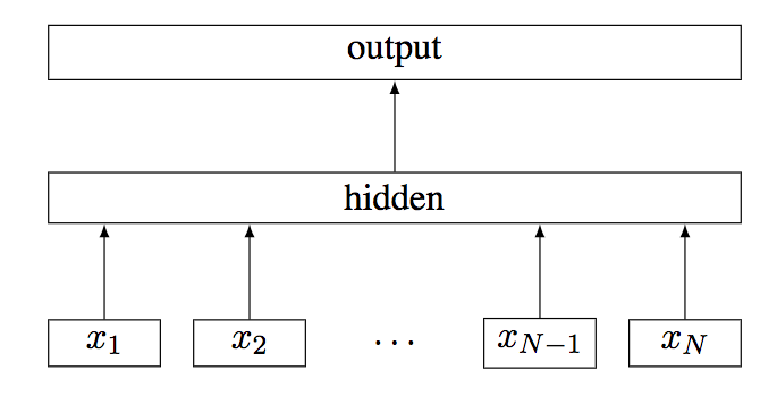

In [2]:
i = img.imread('1.png')

# remove all unecessary stuff and display the image
plt.rcParams['figure.figsize'] = (13, 13)
plt.axis('off')
plt.imshow(i)

In [3]:
# init an empty parameter set with a defaultdict
parms = defaultdict(dict)

parms['label_size'] = 10
parms['batch_size'] = 10
parms['vocab_size'] = 20
parms['learn_rate'] = 0.1

# Problem Statement

#### Some metadata about the dataset
NIPS is a machine learning conference focussed on diverse machine learning topics ranging from neural networks, deep learning etc. The dataset that would be used for the experiment is a time series collection of scholarly data that includes mostly textual data. The papers range from the timeline `1987` - `2017`. 

#### The research question
Can we use `fastText` to build a word embedding model that would cluster scholarly papers on the basis of topic and is there a significant computational advantange of using `fastText` over a normal `word2vec` model.

#### what is word2vec ?
Vectorization in linguistics and natural language processing is a process where words/text are mapped into vectors so that there is a numerical model of the text build for the machine to easily understand the nature of the text. `word2vec` is a vectorization technique that represents the target words of a corpus into a neural network where the hidden layer encodes the word representation. `word2vec` conceptually works with two types of implementations:
- `skip-gram`:
       A neural network representation technique where the input is the target word and the outputs are the words surrounding the target words. The input and the outputs are generally based out of the same dimension. The hidden layer for the neural network is equal to the word embedding size. The activation function is applied on each element so that it could each element of the output vector describe how a specific word will appear in the context. This model is efficient for understanding relationship between two vectors
- `CBOW`:
       A continuous bag of words representation that is similar to the skip-gram, except there is small change in the input and output. Also, the word vectors are generated differently in a Skip-gram model and a CBOW model. All the examples with the target word as target are fed into the networks and taking the average of the extracted hidden layer.
   
#### what is fastText ?
fastText is a library for efficient learning of word representations and sentence classification. Instead of feeding individual words into the neural networks, it breaks the words into several n-grams. 
    

# Baseline Deep learning models - a mutli-threaded skip-gram word2vec model 

# Train the fastText model

In [4]:
# read the csv files
papers = pd.read_csv('~/Documents/data/nips/papers.csv')
author = pd.read_csv('~/Documents/data/nips/authors.csv')
p_auth = pd.read_csv('~/Documents/data/nips/paper_authors.csv')

# extract the keywords from the scholarly papers
def remove_unecessary_stuff(text):
    useless_symbols = ['\x0c','\n']
    for symbols in useless_symbols:
        text = text.replace(symbols, ' ')
    final = re.sub('^[a-zA-Z]', ' ', text)
    return final.lower()

# stem
def stem_the_sentence(tokens):
    return [stemmer('english').stem(token) for token in tokens]

# tokenize
def tokenize_and_stem(sentence):
    # create a dict and stem every token in a given sentence
    remove_punct_map = dict((ord(characters), None) for characters in string.punctuation)
    return stem_the_sentence(tokenize(sentence.lower().translate(remove_punct_map)))

def tokenize_the_sentence(sentence):
    # create a dict and stem every token in a given sentence
    remove_punct_map = dict((ord(characters), None) for characters in string.punctuation)
    return tokenize(sentence.lower().translate(remove_punct_map))

# Test the fastText model

In [5]:
# test
%time a = [tokenize_the_sentence(papers['paper_text'][each]) for each in log_progress(range(0, len(papers['paper_text'])))]

CPU times: user 1min 57s, sys: 1.17 s, total: 1min 58s
Wall time: 1min 59s


# CPU time the fastText model

In [6]:
total_words = sum(list(map(len, a)))
print(total_words)

%time fast_text_model = FastText(a, size=100, window=5, min_count=5, workers=4, sg=1)

33014648
CPU times: user 46min 27s, sys: 18.3 s, total: 46min 45s
Wall time: 14min


# CPU time for the Word2Vec model

In [7]:
print(total_words)

%time word_2_vec = Word2Vec(a, size=100, window=5, min_count=5, workers=4, sg=1)

33014648
CPU times: user 21min 15s, sys: 9.69 s, total: 21min 24s
Wall time: 5min 42s


In [8]:
n_features = 1000
n_topics = 8
n_top_words = 10

tfidf_vectorizer = TfidfVectorizer(max_df=0.95, min_df=2,max_features=n_features,stop_words='english')
%time tfidf = tfidf_vectorizer.fit_transform(papers['paper_text'])

CPU times: user 23.4 s, sys: 376 ms, total: 23.8 s
Wall time: 24.1 s


In [9]:
total_words = sum(list(map(len, a[:1000])))
print(total_words)

3121211


In [11]:
fast_text_model.doesnt_match("breakfast cereal dinner lunch".split())

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `doesnt_match` (Method will be removed in 4.0.0, use self.wv.doesnt_match() instead).
  """Entry point for launching an IPython kernel.


'breakfast'

In [12]:
sentence_obama = 'Obama speaks to the media in Illinois'.lower().split()
sentence_president = 'The president greets the press in Chicago'.lower().split()

# Remove their stopwords.
from nltk.corpus import stopwords
stopwords = stopwords.words('english')
sentence_obama = [w for w in sentence_obama if w not in stopwords]
sentence_president = [w for w in sentence_president if w not in stopwords]

# Compute WMD.
distance = fast_text_model.wmdistance(sentence_obama, sentence_president)
distance

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:11: DeprecationWarning: Call to deprecated `wmdistance` (Method will be removed in 4.0.0, use self.wv.wmdistance() instead).
  # This is added back by InteractiveShellApp.init_path()


3.330094809259415